# **Modelo de ML para prever cancelamento de contratos**

Neste projeto, estaremos desenvolvendo e avaliando um modelo de aprendizado de máquina com o propósito de antecipar o churn das empresas que utilizam os serviços da empresa XYZ, utilizando diversas variáveis como base para a previsão.

Os negócios da empresa XYZ dependem parcialmente de receita recorrente, o que envolve contratos mensais, trimestrais ou anuais com empresas que utilizam seus serviços. Portanto, é importante identificar o potencial churn com antecedência e entender quais aspectos influenciam o churn. O projeto tem a seguinte estrutura:

    - Análise exploratória de dados.
    - Pré-processamento de dados.
    - Desenvolvimento e avaliação do modelo.
    - Conclusões finais.

Cada etapa desempenha um papel crucial na compreensão da dinâmica do churn das empresas que utilizam os serviços da XYZ, permitindo uma abordagem mais informada e estratégica para mitigar a perda de clientes.

## Análise exploratória de dados

A análise exploratória de dados permite identificar padrões, tendências e relações entre as variáveis, oferecendo insights valiosos para a construção do modelo preditivo. Durante esse processo, enfrentamos desafio associados à presença de valores ausentes, uma vez que esse elemento pode exercer um impacto significativo no desempenho de um modelo. Realizamos os passos fundamentais na construção de um modelo robusto, incluindo:

* visualização de dados;
* criação de variáveis novas;
* solução do problema de valores ausentes;

Começamos com a importação dos pacotes e bibliotecas necessários para construir e avaliar um modelo de ML.

In [1]:
# Pacotes de processamento de dados
import numpy as np
import pandas as pd

# Pacote de visualização de dados
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Permite ver todas as colunas, evitando que o Jupyter as esconde
pd.set_option('display.max_columns', None)

# Pacotes para modelagem de dados
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Ajuda construir gráfico de função importance
from xgboost import plot_importance

# Pacote para balanceamento de classes
from sklearn.base import OneToOneFeatureMixin
from imblearn.under_sampling import RandomUnderSampler

import warnings
#warnings.filterwarnings('ignore')

# Permite salvar os modelos depois de ajuste
import pickle

In [2]:
# Abrimos os dados
path = '~/export?format=csv&gid=2040005573'
df = pd.read_csv(path)
df.head()

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,Frequência de utilização de feature do sistema: Emissão de nota fiscal,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn
0,1,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,"R$ 29,85","R$ 29,85",Não
1,2,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Trimestral,0,No,Boleto - mês a mês,"R$ 56,95","R$ 1.889,50",Não
2,3,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - mês a mês,"R$ 53,85","R$ 108,15",Sim
3,4,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Trimestral,0,No,Cartão de crédito - pagamento único,"R$ 42,30","R$ 1.840,75",Não
4,5,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,"R$ 70,70","R$ 151,65",Sim


In [3]:
# Conhecemos a estrutura de dataset
df.shape

(7043, 22)

O dataset contem $7043$ linhas e $22$ colunas.

In [4]:
# Verificamos os nomes de colunas
df.columns

Index(['ID', 'Tipo de empresa', 'Fundação da empresa',
       'Possui mais de um sócio', 'Funcionários', 'Meses de permanência ',
       'Utiliza serviços financeiros', 'PossuiContador',
       'Faz conciliação bancária',
       'Frequência de utilização de feature do sistema: Módulo financeiro',
       'Frequência de utilização de feature do sistema: Emissão de nota fiscal',
       'Frequência de utilização de feature do sistema: Integração bancária',
       'Frequência de utilização de feature do sistema: Módulo de vendas',
       'Frequência de utilização de feature do sistema: Relatórios',
       'Frequência de utilização de feature do sistema: Utilização de APIs de integração',
       'Contrato', 'Emite boletos', 'Emite boletos.1', 'Tipo de pagamento',
       'Receita mensal', 'Receita total', 'Churn'],
      dtype='object')

Observamos que o nome da coluna `Meses de permanência ` tem um espaço branco no final, usamos a função `str.strip()` para eliminar os espaços em branco do início e do final em nomes das colunas.

In [5]:
# Removemos os espaços em branco
df.columns = df.columns.str.strip()

In [6]:
# Verificamos uma visão geral concisa das informações sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                                                            Non-Null Count  Dtype 
---  ------                                                                            --------------  ----- 
 0   ID                                                                                7043 non-null   int64 
 1   Tipo de empresa                                                                   7043 non-null   object
 2   Fundação da empresa                                                               7043 non-null   int64 
 3   Possui mais de um sócio                                                           7043 non-null   object
 4   Funcionários                                                                      7043 non-null   object
 5   Meses de permanência                                                              7043 non-null   int64 
 6   Utiliza 

Logo podemos observar que
* As colunas `PossuiContador` e `Receita Total` tem $682$ e $11$ valores nulos, respectivamente.
* Há duas colunas iguais `Emite boletos` e `Emite boletos.1`, a primeira coluna sendo binária, e a segunda é do tipo Object.
* As colunas `Receita mensal` e `Receita total` contem dados do tipo Object, e será necessário transforma-los em valores do tipo float, eliminando o símbolo **R$**.

In [7]:
# Confirmamos valores ausentes

df.isna().sum()

ID                                                                                    0
Tipo de empresa                                                                       0
Fundação da empresa                                                                   0
Possui mais de um sócio                                                               0
Funcionários                                                                          0
Meses de permanência                                                                  0
Utiliza serviços financeiros                                                          0
PossuiContador                                                                      682
Faz conciliação bancária                                                              0
Frequência de utilização de feature do sistema: Módulo financeiro                     0
Frequência de utilização de feature do sistema: Emissão de nota fiscal                0
Frequência de utilização de feat

Dado nosso foco em não renovação de contrato, a coluna `Churn` é fundamental. Analisamos o balanceamento das amostras das classes da variável dependente `Churn`:

In [8]:
round(df.Churn.value_counts()/df.shape[0] * 100,2)

Churn
Não    73.46
Sim    26.54
Name: count, dtype: float64

As classes da variável `Churn` são desbalanceadas, com $26,54$% de churn. Construir um modelo de previsão com a variável desbalanceada pode dar alguns problemas. Isso acontece porque o padrão dos dados para a classe dominante vai se sobressair em relação aos da classe com menor frequência. No nosso caso, a classe com menor frequência - churn - é justamente a que temos interesse em prever, o que torna os problemas ainda maiores. Trataremos o problema na parte de construção de modelo ML.

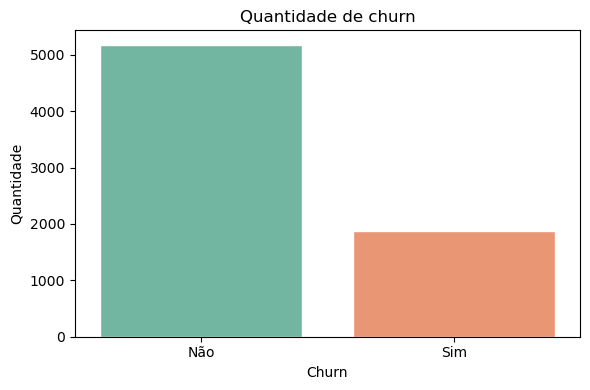

In [9]:
# Plotar um gráfico de barras para ver o balanceamento 
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette(sns.color_palette("Set2"))
count = df['Churn'].value_counts()
sns.countplot(x='Churn', data=df)
ax.set_xlabel('Churn')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de churn');
plt.tight_layout()

Resolvemos os problemas do tipo de dados nas colunas `Receita mensal` e `Receita total` e valores nulos na `Receita total`.

In [10]:
# Função para converter valores de texto em valor decimal

def converter(valor):
    if pd.isnull(valor):
        return None
    else:
        valor = valor.replace('R$', '').replace('.', '').replace(',', '.')
        return float(valor)

In [11]:
# Aplicar a função aos dados em colunas 'Receita mensal' e 'Receita total'

df['Receita mensal'] = df['Receita mensal'].apply(converter)
df['Receita total'] = df['Receita total'].apply(converter)

df.head()

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,Frequência de utilização de feature do sistema: Emissão de nota fiscal,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn
0,1,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,29.85,29.85,Não
1,2,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Trimestral,0,No,Boleto - mês a mês,56.95,1889.50,Não
2,3,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - mês a mês,53.85,108.15,Sim
3,4,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Trimestral,0,No,Cartão de crédito - pagamento único,42.30,1840.75,Não
4,5,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,70.70,151.65,Sim


Usamos os dados da coluna `Receita mensal` para preencher os dados nulos na coluna `Receita total`.

In [12]:
# Lidando com valores nulos na coluna 'Receita total'

df['Receita total'] = df['Receita total'].fillna(df['Receita mensal'] * 12)
df['Receita total'].isnull().sum()

0

Antes de proceder para visualização de dados, vamos explorar as estatísticas descritivas dos dados com o objetivo de identificar possíveis valores atípicos (outliers).

In [13]:
# Verificamos as estatísticas descritivas dos dados

df.describe()

,ID,Fundação da empresa,Meses de permanência,Emite boletos,Receita mensal,Receita total
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3522.000000,2016.736476,32.371149,0.592219,64.761692,2280.510564
std,2033.283305,4.582311,24.559481,0.491457,30.090047,2266.124166
min,1.000000,2001.000000,0.000000,0.000000,18.250000,18.800000
25%,1761.500000,2016.000000,9.000000,0.000000,35.500000,400.150000
50%,3522.000000,2018.000000,29.000000,1.000000,70.350000,1394.550000
75%,5282.500000,2020.000000,55.000000,1.000000,89.850000,3786.600000
max,7043.000000,2021.000000,72.000000,1.000000,118.750000,8684.800000


Ao analisar os números em `Meses de permanência`, `Receita mensal` e `Receita total` podemos concluir que não há presença de outliers nessas variáveis. Prosseguimos para visualização de dados.

#### Tipo de empresa

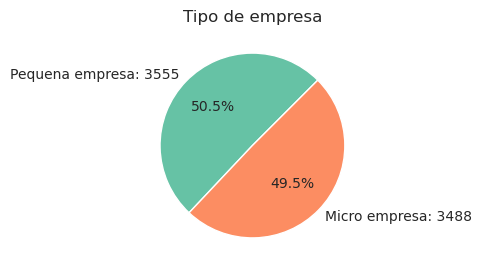

In [14]:
# Pie chart 'Tipo de empresa'

fig = plt.figure(figsize=(3,3))
data=df['Tipo de empresa'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%', startangle=45
        )
plt.title('Tipo de empresa');

O dataset está dividido quase igual entre as micro e pequenas empresas. 

In [15]:
# Taxa de churn por tipo de empresa

df['Tipo de empresa'].loc[df.Churn == 'Sim'].value_counts() / df['Tipo de empresa'].value_counts() * 100

Tipo de empresa
Micro empresa      26.920872
Pequena empresa    26.160338
Name: count, dtype: float64

A taxa de churn em relação de `Tipo de empresa` é praticamente igual. O tipo de empresa não afeta a taxa de churn nesse dataset.



#### Anos de empresa

Para melhorar a visualização de anos de cada empresa, criamos uma coluna nova `Anos de empresa`. 

In [16]:
# Criamos coluna nova de Anos de empresa

df['Anos de empresa'] = pd.Timestamp.now().year - df['Fundação da empresa']

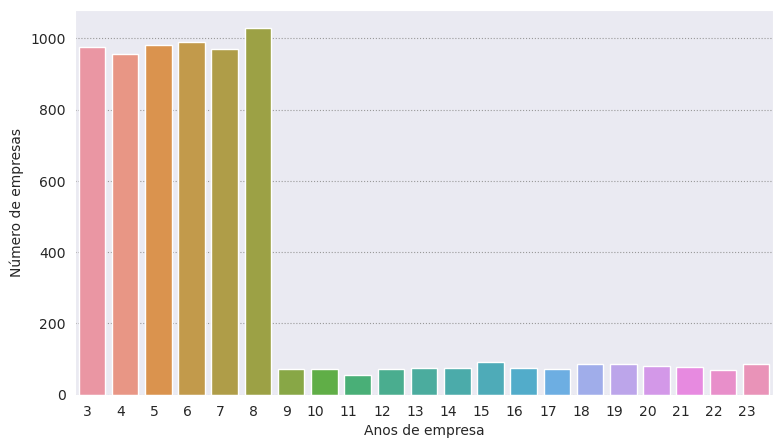

In [17]:
# Visualização Anos de empresa

plt.figure(figsize=(9, 5))
sns.barplot(x=df['Anos de empresa'].value_counts().index,
            y=df['Anos de empresa'].value_counts().values)
plt.xlabel('Anos de empresa')
plt.ylabel('Número de empresas')
plt.xticks(horizontalalignment='right')
plt.show()

As empresas claramente estão divididas em dois grupos: a maioria das empresas tem entre $3$ e $8$ anos, e o resto é distribuido quase igual entre entre $9$ e $23$ anos.

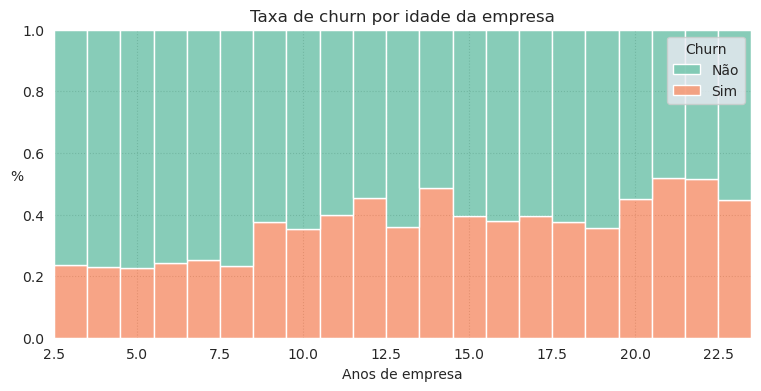

In [18]:
# Visualização de churn por idade da empresa

sns.set_palette(sns.color_palette("Set2"))
plt.figure(figsize=(9,4))
sns.histplot(data=df,
             x='Anos de empresa',
             bins=range(3,24),
             hue='Churn',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Taxa de churn por idade da empresa');

A taxa de churn é menor entre as empresas do primeiro grupo (3-8 anos) com distribuição quase igual, e tende aumentar no grupo de empresas entre 9-23 anos de mercado. Esse padrão pode ser influenciado por diversos fatores, como mudanças na concorrência, evolução do mercado, necessidades e expectativas dos clientes ao longo do tempo, entre outros.


#### Possui mais de um sócio

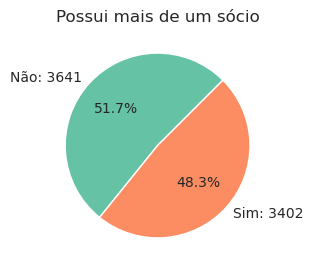

In [66]:
# Pie chart 'Possui mais de um sócio'

fig = plt.figure(figsize=(3,3))
data=df['Possui mais de um sócio'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%', startangle=45
        )
plt.title('Possui mais de um sócio');

A maioria das empresas representadas nos dados não possui mais de um sócio. 

In [67]:
# Taxa de churn por 'Possui mais de um sócio'

df['Possui mais de um sócio'].loc[df.Churn == 'Sim'].value_counts() / df['Possui mais de um sócio'].value_counts() * 100

Possui mais de um sócio
Não    32.957979
Sim    19.664903
Name: count, dtype: float64

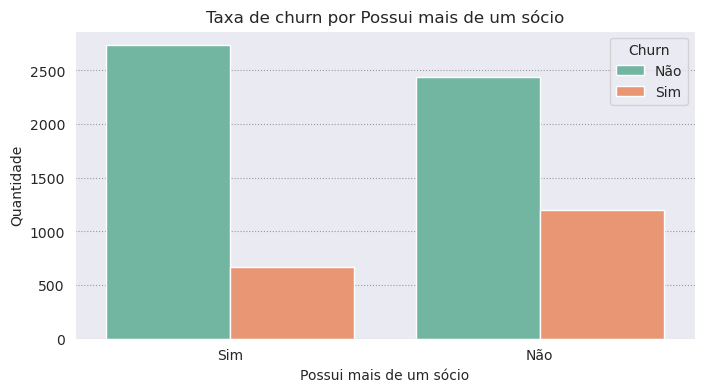

In [68]:
# Gráfico de barras de churn por 'Possui mais de um sócio'
plt.figure(figsize=(8, 4))
sns.set_palette(sns.color_palette("Set2"))
sns.countplot(data=df, x='Possui mais de um sócio', hue='Churn')
plt.xlabel('Possui mais de um sócio')
plt.ylabel('Quantidade')
plt.title('Taxa de churn por Possui mais de um sócio')
plt.legend(title='Churn', loc='upper right');

Empresas que possuem mais de um sócio têm uma taxa de churn menor, de 19.7%. Possivelmente, o número de sócios pode estar correlacionado com a taxa de churn, indicando uma possível área de investigação adicional sobre como a estrutura societária pode influenciar a fidelidade dos clientes.

#### Funcionários

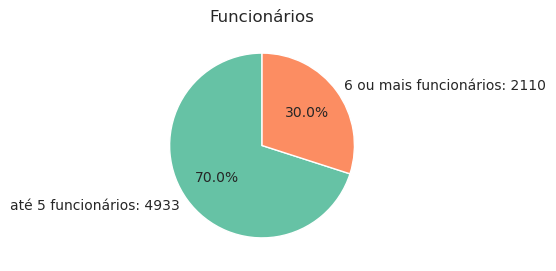

In [75]:
# Pie chart Funcionários

fig = plt.figure(figsize=(3,3))
data=df.Funcionários.value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%', startangle=90
        )
plt.title('Funcionários');

A maioria das empresas (70 %) possuem até 5 funcionários. 

In [76]:
# Taxa de churn por 'Funcionários'

df.Funcionários.loc[df.Churn == 'Sim'].value_counts() / df.Funcionários.value_counts() * 100

Funcionários
até 5 funcionários        31.279140
6 ou mais funcionários    15.450237
Name: count, dtype: float64

Empresas com 6 ou mais funcionários têm uma taxa de churn menor em comparação com aquelas com até 5 funcionários, com uma taxa de aproximadamente 15.45%. Isso pode indicar que empresas maiores podem ter recursos e capacidade organizacional adicionais para manter o contrato com a XYZ.

### Faz conciliação bancária

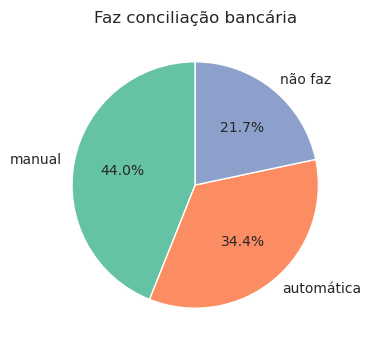

In [79]:
# Pie chart Faz conciliação bancária

fig = plt.figure(figsize=(4,4))
data=df['Faz conciliação bancária'].value_counts()
plt.pie(data.values, labels=data.index,
        autopct='%1.1f%%', startangle=90)
plt.title('Faz conciliação bancária');

In [80]:
# Taxa de churn por 'Faz conciliação bancária'

df['Faz conciliação bancária'].loc[df.Churn == 'Sim'].value_counts() / df['Faz conciliação bancária'].value_counts() * 100

Faz conciliação bancária
manual        41.892765
automática    18.959108
não faz        7.404980
Name: count, dtype: float64

Empresas que realizam conciliação bancária manualmente tendem a ter uma taxa de churn significativamente maior em comparação com aquelas que utilizam métodos automáticos ou que não realizam a conciliação. Isso pode indicar a importância de processos mais eficientes e automatizados na gestão financeira das empresas para a retenção de empresas-clientes.


#### Meses de permanência

Vamos analisar o tempo de permanência das empresas na XYZ. Da estatística descritiva já sabemos que o mínimo de permanência é 0 meses, o máximo é 72 meses (6 anos), e o tempo médio é 32 meses (2 anos e 6 meses). Vamos ver a distribuição desses dados.

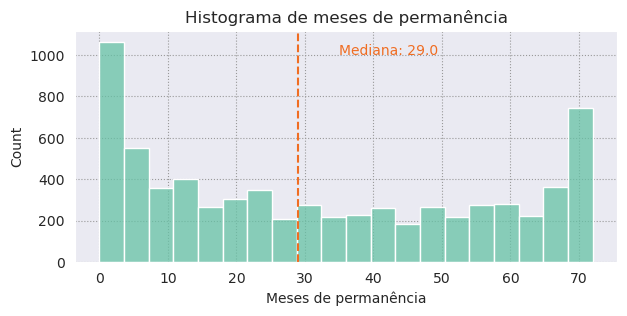

In [37]:
# Histograma de meses de permanência

plt.figure(figsize=(7,3))
sns.histplot(x=df['Meses de permanência'], bins=20)
median = df['Meses de permanência'].median()
plt.axvline(median, color='#f06d22', linestyle='--')
plt.text(35, 1000, f'Mediana: {median}', color='#f06d22')
plt.title('Histograma de meses de permanência');

A distribuição é pouco simétrica, por isso o valor médio e mediana são diferentes. No entanto, podemos observar que a maioria das empresas concentrarda bem no começo com pouco meses de permanência, e no final com mais meses de permanência. É um padrão interessante se observar.

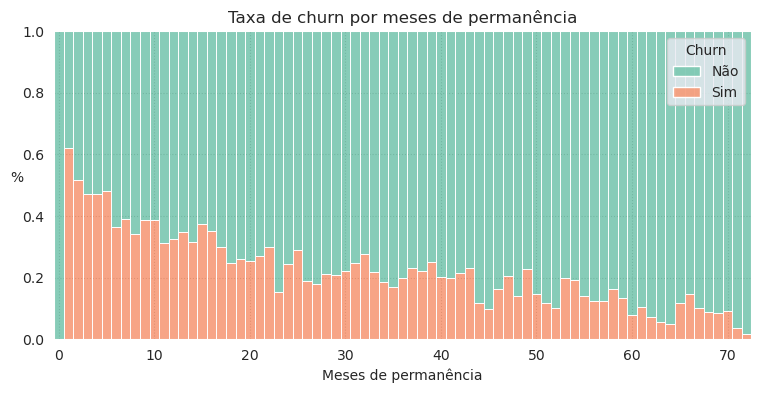

In [20]:
# Visualização da taxa de churn por meses de permanência

sns.set_palette(sns.color_palette("Set2"))
plt.figure(figsize=(9,4))
sns.histplot(data=df,
             x='Meses de permanência',
             bins=range(1,73),
             hue='Churn',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Taxa de churn por meses de permanência');

É razoável esperar que a taxa de churn diminua à medida que o número de meses de permanência aumenta. Isso porque clientes que permanecem com um serviço por um período mais longo tendem a estar mais satisfeitos ou terem uma maior fidelidade ao produto ou serviço. Portanto, é esperado que a taxa de churn seja menor entre os clientes que estão há mais tempo na XYZ. 

A observação de um aumento no churn em empresas com 9 a 23 anos de mercado não contradiz necessariamente a relação geral entre o churn e o tempo de permanência. Pode ser um fenômeno específico relacionado às características desse grupo de empresas. É importante lembrar que a maioria das empresas-clientes da XYZ tem entre 3 e 8 anos de idade. Pode ser que as empresas nessa faixa de idade tenham um comportamento diferente das empresas mais antigas, o que pode influenciar os resultados da análise da taxa de churn. 


#### Utilização de serviços financeiros

Vamos analisar os dados de utilização de serviços financeiros.

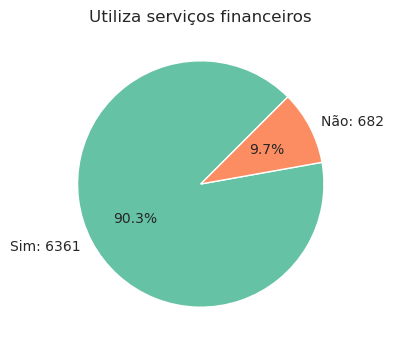

In [21]:
# Pie chart de utilização de serviços financeiros

fig = plt.figure(figsize=(4,4))
data=df['Utiliza serviços financeiros'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%', startangle=45
        )
plt.title('Utiliza serviços financeiros');

A maioria das empresas utilizam os serviços financeiros. Examinamos a taxa de churn.

In [22]:
# Taxa de churn por utilização de serviços financeiros

df['Utiliza serviços financeiros'].loc[df.Churn == 'Sim'].value_counts() / df['Utiliza serviços financeiros'].value_counts() * 100

Utiliza serviços financeiros
Sim    26.709637
Não    24.926686
Name: count, dtype: float64

A taxa de churn é balanceada entre empresas que utilizam e não utilizam serviços financeiros, por isso seguimos sem visualização desse fato. 

#### Possui contador

Reparamos alguns problemas ao trabalhar com dados da `PossuiContador`:

In [23]:
df['PossuiContador'].unique()

array([nan, 'Não ', 'Sim'], dtype=object)

Após breve análise descobrimos que `Não ` na coluna 'PossuiContador' possuem espaços extras, vamos remover este espaço branco.

In [24]:
# Remover espaços extras dos valores na coluna 'PossuiContador'
df['PossuiContador'] = df['PossuiContador'].str.strip()

Além disso, há 682 valores nulos nessa coluna. Usamos a função `.mode()` de Pandas (que não existe no Numpy!), que calcula valor mais comum na coluna `PossuiContador`.

In [25]:
# Substitui os valores NaN pela moda
df['PossuiContador'].fillna(df['PossuiContador'].mode()[0], inplace=True)

In [26]:
# Verificamos
df['PossuiContador'].isnull().sum()

0

O problema com valores nulos foi resolvido. Visualizamos os dados:

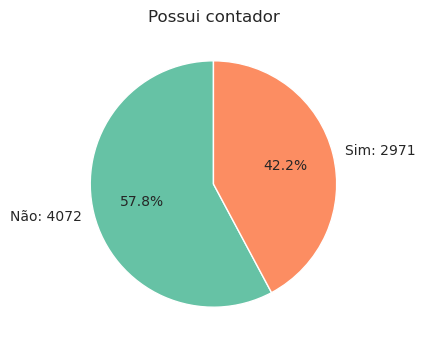

In [27]:
# Pie chart de PossuiContador

fig = plt.figure(figsize=(4,4))
data=df['PossuiContador'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%', startangle=90
        )
plt.title('Possui contador');

Um pouco mais da metade não tem contador na empresa. 

In [28]:
# Taxa de churn por PossuiContador

df.PossuiContador.loc[df.Churn == 'Sim'].value_counts() / df.PossuiContador.value_counts() * 100

PossuiContador
Não    25.024558
Sim    28.609896
Name: count, dtype: float64

A taxa de churn é balanceada nesse caso. 

#### Tipo de contrato

Vamos visualizar os dados por tipo de contrato. 

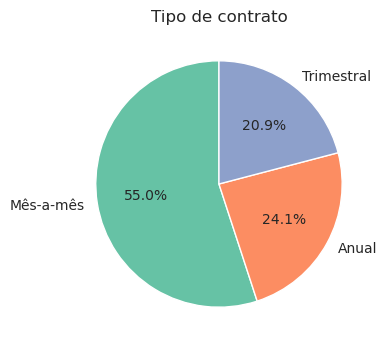

In [29]:
# Pie chart por tipo de contrato

fig = plt.figure(figsize=(4,4))
data=df['Contrato'].value_counts()
plt.pie(data.values, labels=data.index,
        autopct='%1.1f%%', startangle=90)
plt.title('Tipo de contrato');

Existem três tipos de contrato: Mês-a-mês, Trimestral e Anual. Metade das empresas prefere contrato mês-a-mês, com 55%, enquanto a outra metade é dividida entre contrato trimestral (20.9%) e anual (24.1%). Examinamos e visualizamos a taxa de churn.

In [30]:
# Taxa de churn por tipo de contrato

df.Contrato.loc[df.Churn == 'Sim'].value_counts()/df.Contrato.value_counts() *100

Contrato
Anual          2.831858
Mês-a-mês     42.709677
Trimestral    11.269518
Name: count, dtype: float64

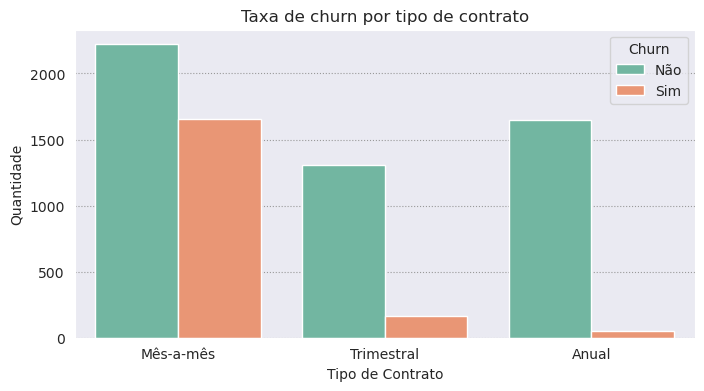

In [31]:
# Criando o gráfico de barras agrupadas
plt.figure(figsize=(8, 4))
sns.set_palette(sns.color_palette("Set2"))
sns.countplot(data=df, x='Contrato', hue='Churn')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Quantidade')
plt.title('Taxa de churn por tipo de contrato')
plt.legend(title='Churn', loc='upper right');

O contrato `Mês-a-mês` apresenta a maior taxa de churn, com 42.71% dos clientes com churn, possivelmente devido à flexibilidade oferecida por esse tipo de contrato.

O contrato `Trimestral` ainda tem uma taxa de churn significativa de 11.27%. Embora seja menor do que a taxa para contratos mensais, ainda indica uma proporção considerável de clientes que não renovam o contrato.

E o contrato `Anual` apresenta a menor taxa de churn, com apenas de 2.83% dos clientes não renovando o contrato. Isso sugere que os clientes com contratos anuais têm maior probabilidade de permanecerem com o serviço ao longo do tempo, o que pode estar relacionado a fatores como comprometimento a longo prazo ou benefícios financeiros associados a esse tipo de contrato.

Podemos concluir que **existe uma correlação entre o período de contrato e a taxa de churn**, com contratos mais longos apresentando taxas de churn mais baixas. Isso destaca a importância de estratégias de retenção de clientes diferenciadas, dependendo do tipo de contrato oferecido pela empresa.

#### Tipo de pagamento 

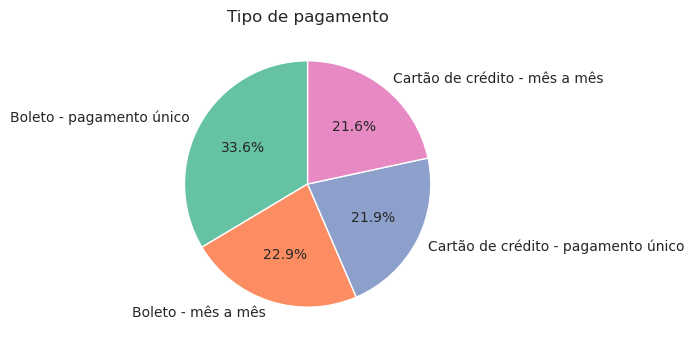

In [32]:
# Pie chart do tipo de pagamento

fig = plt.figure(figsize=(4,4))
data=df['Tipo de pagamento'].value_counts()
plt.pie(data.values, labels=data.index,
        autopct='%1.1f%%', startangle=90)
plt.title('Tipo de pagamento');

A maior parte das empresas prefere pagamento único via boleto. O restante está distribuído quase igualmente entre boleto - mês a mês, cartão de crédito - pagamento único e cartão de crédito - mês a mês. Exploramos a taxa de churn.

In [33]:
# Taxa de churn por tipo de pagamento

df['Tipo de pagamento'].loc[df.Churn == 'Sim'].value_counts() / df['Tipo de pagamento'].value_counts() * 100

Tipo de pagamento
Boleto - pagamento único               45.285412
Boleto - mês a mês                     19.106700
Cartão de crédito - pagamento único    16.709845
Cartão de crédito - mês a mês          15.243101
Name: count, dtype: float64

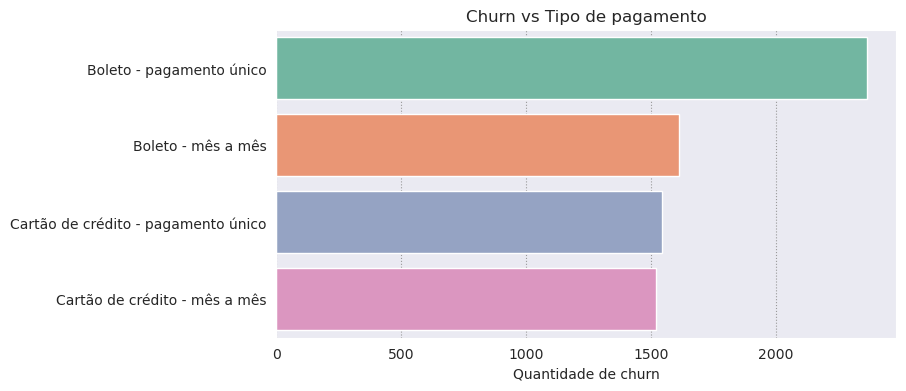

In [34]:
# Visualização de taxa de churn por tipo de pagamento

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax = sns.barplot(x=list(df['Tipo de pagamento'].value_counts().values), y=list(df['Tipo de pagamento'].value_counts().index), order= df['Tipo de pagamento'].value_counts().sort_values(ascending = False).index, ax = ax)
ax.set_xlabel('Quantidade de churn')
#ax.set_ylabel('Tipo de pagamento')
ax.set_title('Churn vs Tipo de pagamento');

O pagamento único via boleto apresenta a maior taxa de churn, com 45.29%. Isso pode indicar uma proporção significativa de clientes que optam por não renovar o contrato após efetuarem o pagamento único via boleto, talvez devido a uma insatisfação com o serviço ou mudança nas necessidades. 

O pagamento no cartão de crédito - Mês a Mês o menor taxa de churn com 15.24%.

As taxas de churn variam entre os diferentes tipos de pagamento, e isso sugere a importância de entender os motivos e padrões de cancelamento associados a cada forma de pagamento para implementar estratégias eficazes de retenção de clientes.

### Resumo de EDA

* As classes da variável Churn são desbalanceadas.
* A taxa de churn é menor entre as empresas com 3-8 anos de idade, e tende aumentar no grupo de empresas entre 9-23 anos de mercado. Esse padrão pode ser influenciado por diversos fatores, como mudanças na concorrência, evolução do mercado, necessidades e expectativas dos clientes ao longo do tempo, entre outros.
* Empresas que possuem mais de um sócio têm uma taxa de churn menor, de 19.7%. Possivelmente, o número de sócios pode estar correlacionado com a taxa de churn, indicando uma possível área de investigação adicional sobre como a estrutura societária pode influenciar a fidelidade dos clientes.
* Empresas com 6 ou mais funcionários têm uma taxa de churn menor em comparação com aquelas com até 5 funcionários, com uma taxa de aproximadamente 15.45%. Isso pode indicar que empresas maiores podem ter recursos e capacidade organizacional adicionais para manter o contrato com XYZ.
* Empresas que realizam conciliação bancária manualmente tendem a ter uma taxa de churn significativamente maior em comparação com aquelas que utilizam métodos automáticos ou que não realizam a conciliação. Isso pode indicar a importância de processos mais eficientes e automatizados na gestão financeira das empresas para a retenção de empresas-clientes.
* A taxa de churn diminua à medida que o número de meses de permanência na XYZ aumenta. Isso porque clientes que permanecem com um serviço da XYZ por um período mais longo tendem a estar mais satisfeitos ou terem uma maior fidelidade ao produto ou serviço.
* Existe uma correlação entre o período de contrato e a taxa de churn, com contratos mais longos apresentando taxas de churn mais baixas. Isso destaca a importância de estratégias de retenção de clientes diferenciadas, dependendo do tipo de contrato oferecido pela empresa.
* As taxas de churn variam entre os diferentes tipos de pagamento, e isso sugere a importância de entender os motivos e padrões de cancelamento associados a cada forma de pagamento para implementar estratégias eficazes de retenção de empresas-clientes.

## Pré-processamento de dados

Nesta parte, fazemos
* codificação de variáveis categóricas;
* normalização dos dados.

É a etapa de transformação de dados brutos em uma forma que o modelo de aprendizado de máquina possa entender. 

### Codificando as variáveis categóricas

Vamos realizar a conversão do tipo de dados das variáveis categóricas para binários. Essa modificação é fundamental para a correta aplicação e treinamento de um modelo de regressão logística. Usaremos os metodos _One-hot encoding_ e variáveis _dummy_.

In [86]:
# Dfinimos a variável target

df['Churn'] = df['Churn'].replace(('Sim', 'Não'), (1, 0))

Vamos realizar a conversão do tipo de dados das variáveis `Possui mais de um sócio`, `Utiliza serviços financeiros`, `PossuiContador` para binários usando a função `map()` do pandas.

In [87]:
# Definir um dicionário de mapeamento
mapeamento = {'Sim': 1, 'Não': 0}

# Aplicar o mapeamento para cada coluna
for coluna in ['Possui mais de um sócio', 'Utiliza serviços financeiros', 'PossuiContador']:
    df[coluna] = df[coluna].map(mapeamento)

df.tail()

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,Frequência de utilização de feature do sistema: Emissão de nota fiscal,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Contrato,Emite boletos,Emite boletos.1,Tipo de pagamento,Receita mensal,Receita total,Churn,Anos de empresa
7038,7039,Pequena empresa,2018,1,6 ou mais funcionários,24,1,1,automática,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Uso frequente,Uso frequente,Trimestral,1,Yes,Boleto - mês a mês,84.80,1990.50,0,6
7039,7040,Micro empresa,2020,1,6 ou mais funcionários,72,1,1,manual,Pouco uso,Uso frequente,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Trimestral,1,Yes,Cartão de crédito - mês a mês,103.20,7362.90,0,4
7040,7041,Micro empresa,2019,1,6 ou mais funcionários,11,0,0,automática,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - pagamento único,29.60,346.45,0,5
7041,7042,Pequena empresa,2003,1,até 5 funcionários,4,1,1,manual,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Yes,Boleto - mês a mês,74.40,306.60,1,21
7042,7043,Pequena empresa,2017,0,até 5 funcionários,66,1,0,manual,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Uso frequente,Uso frequente,Anual,1,Yes,Cartão de crédito - pagamento único,105.65,6844.50,0,7


Usamos `Label Encoder` para próximas colunas:

In [88]:
# Cria um dicionário para guardar cada LabelEncoder por coluna
encoders = {}

colunas_para_codificar = ['Tipo de empresa', 'Funcionários', 
       'Utiliza serviços financeiros', 'Faz conciliação bancária',
       'Frequência de utilização de feature do sistema: Módulo financeiro',
       'Frequência de utilização de feature do sistema: Emissão de nota fiscal',
       'Frequência de utilização de feature do sistema: Integração bancária',
       'Frequência de utilização de feature do sistema: Módulo de vendas',
       'Frequência de utilização de feature do sistema: Relatórios',
       'Frequência de utilização de feature do sistema: Utilização de APIs de integração', 'Emite boletos.1']

label_encoder = LabelEncoder()

# Aplicar o LabelEncoder para cada coluna
for coluna in colunas_para_codificar:
    df[coluna] = label_encoder.fit_transform(df[coluna])
    encoders[coluna] = label_encoder  # Salva o encoder ajustado para uso posterior

# One-Hot Encoding
df = pd.get_dummies(df, columns=['Tipo de pagamento','Contrato'])

In [89]:
# Converter valores booleanos para inteiros (1 ou 0)
df = df.astype(int)

In [90]:
df.head()

,ID,Tipo de empresa,Fundação da empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,Frequência de utilização de feature do sistema: Emissão de nota fiscal,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Emite boletos,Emite boletos.1,Receita mensal,Receita total,Churn,Anos de empresa,Tipo de pagamento_Boleto - mês a mês,Tipo de pagamento_Boleto - pagamento único,Tipo de pagamento_Cartão de crédito - mês a mês,Tipo de pagamento_Cartão de crédito - pagamento único,Contrato_Anual,Contrato_Mês-a-mês,Contrato_Trimestral
0,1,0,2016,1,1,1,0,0,0,1,2,1,1,1,1,1,1,29,29,0,8,0,1,0,0,0,1,0
1,2,1,2018,0,1,34,1,0,0,2,1,2,1,1,1,0,0,56,1889,0,6,1,0,0,0,0,0,1
2,3,1,2021,0,1,2,1,0,0,2,2,1,1,1,1,1,1,53,108,1,3,1,0,0,0,0,1,0
3,4,1,2016,0,1,45,0,0,0,2,1,2,2,1,1,0,0,42,1840,0,8,0,0,0,1,0,0,1
4,5,0,2017,0,1,2,1,0,1,1,1,1,1,1,1,1,1,70,151,1,7,0,1,0,0,0,1,0


Podemos apagar do dataframe as colunas `ID` (não é necessária para o modelo), `Fundação da empresa` (usaremos `Anos de empresa)` e `Emite boletos` (usaremos `Emite boletos.1`.

In [91]:
df = df.drop(columns = ['ID','Fundação da empresa','Emite boletos'])
df.head()

,Tipo de empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,Frequência de utilização de feature do sistema: Emissão de nota fiscal,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Emite boletos.1,Receita mensal,Receita total,Churn,Anos de empresa,Tipo de pagamento_Boleto - mês a mês,Tipo de pagamento_Boleto - pagamento único,Tipo de pagamento_Cartão de crédito - mês a mês,Tipo de pagamento_Cartão de crédito - pagamento único,Contrato_Anual,Contrato_Mês-a-mês,Contrato_Trimestral
0,0,1,1,1,0,0,0,1,2,1,1,1,1,1,29,29,0,8,0,1,0,0,0,1,0
1,1,0,1,34,1,0,0,2,1,2,1,1,1,0,56,1889,0,6,1,0,0,0,0,0,1
2,1,0,1,2,1,0,0,2,2,1,1,1,1,1,53,108,1,3,1,0,0,0,0,1,0
3,1,0,1,45,0,0,0,2,1,2,2,1,1,0,42,1840,0,8,0,0,0,1,0,0,1
4,0,0,1,2,1,0,1,1,1,1,1,1,1,1,70,151,1,7,0,1,0,0,0,1,0


### Matriz de correlação

Vamos gerar uma matriz de correlação de Pearson. As variáveis altamente correlacionadas podem causar multicolinearidade que pode tornar o modelo instável.

In [92]:
# Matriz de correlação
matriz = df.corr(method='pearson')

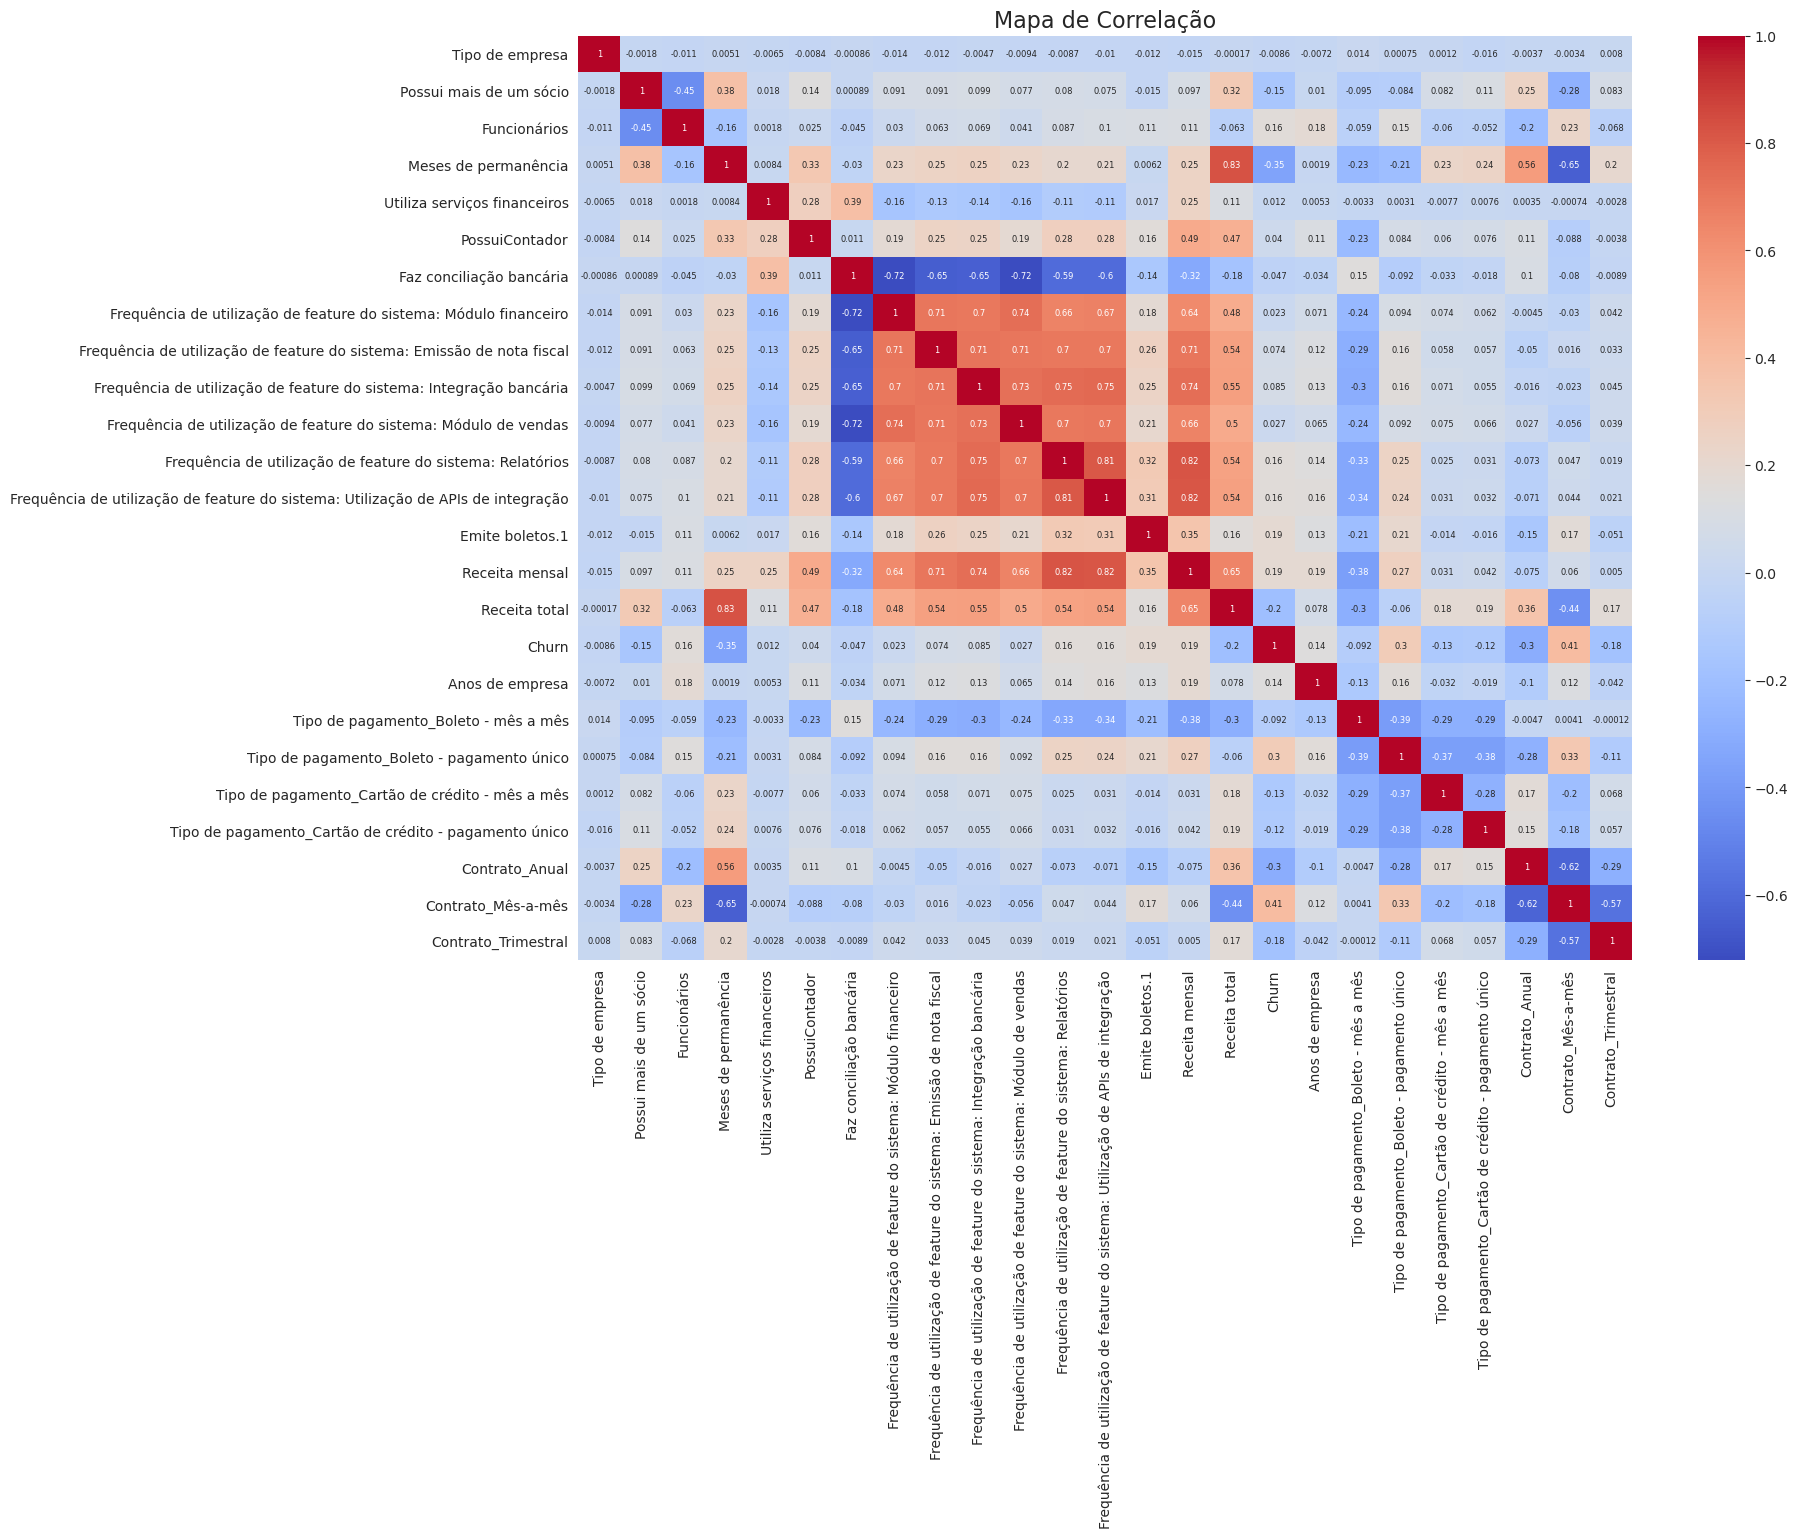

Features removidas: ['Frequência de utilização de feature do sistema: Utilização de APIs de integração', 'Receita mensal', 'Receita mensal', 'Receita total']


In [93]:
# Mapa de calor de correlação

plt.figure(figsize=(17,12))
sns.heatmap(matriz, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title('Mapa de Correlação', fontsize=16)
plt.show();

# Identifique e remova características altamente correlacionadas
threshold = 0.8
to_drop = []

for i in range(len(matriz)):
    for j in range(i):
        if abs(matriz.iloc[i, j]) > threshold:
            colname = matriz.columns[i]
            to_drop.append(colname)

df_dropped = df.drop(columns=to_drop)

print(f"Features removidas: {to_drop}")

Estabelecendo um limite inferior para o coeficiente de correlação em $0.8$, temos que as variáveis `Receita total` e `Meses de permanência` apresentam multicolinearidade, evidenciada pelo coeficiente de correlação igual a $0.83$. Da mesma forma, a variáveil `Receita mensal` e apresenta multicolinearidade em relação das variáveis `Frequência de utilização de feature do sistema: Relatórios` e `Frequência de utilização de feature do sistema: Utilização de APIs de integração` com um coeficiente de correlação de $0.81$.

Podemos examinar quais features estão mais correlacionados com a churn usando a função `corr()`. As colunas mais próximas do topo, que possuem valores mais próximos de 1, são aquelas que estão mais correlacionadas com o churn.

In [94]:
df[df.columns[1:]].corr()['Churn'][:].sort_values(ascending=False).to_frame()

,Churn
Churn,1.000000
Contrato_Mês-a-mês,0.405103
Tipo de pagamento_Boleto - pagamento único,0.301919
Receita mensal,0.193422
Emite boletos.1,0.191825
Frequência de utilização de feature do sistema: Relatórios,0.164673
Funcionários,0.164221
Frequência de utilização de feature do sistema: Utilização de APIs de integração,0.163220
Anos de empresa,0.141872
Frequência de utilização de feature do sistema: Integração bancária,0.084654


As variáveis que têm uma correlação positiva mais forte com `Churn` são `Contrato_Mês-a-mês`, `Tipo de pagamento_Boleto - pagamento único`, `Receita mensal`, `Emite boletos.1` e `Frequência de utilização de feature do sistema: Relatórios`. Isso significa que à medida que essas variáveis aumentam, a probabilidade de churn também tende a aumentar.

Por outro lado, as variáveis com correlação negativa mais forte com `Churn` são `Contrato_Anual`, `Meses de permanência` e `Receita total`. Isso sugere que clientes com contratos anuais, maior tempo de permanência e receita total mais alta tendem a ter uma menor probabilidade de churn.

### Normalização de dados

As variáveis com escalas diferentes afetam a acurácia do modelo. A normalização coloca os dados no intervalo entre 0 e 1 ou -1 e 1, caso haja valores negativos, sem distorcer as diferenças nas faixas de valores. Usamos a função `MinMaxScaler` do `sklearn`.

In [95]:
# Normalização dos dados

scaler = MinMaxScaler()
cols_to_normalize = ['Meses de permanência', 'Anos de empresa', 'Frequência de utilização de feature do sistema: Módulo financeiro',
       'Frequência de utilização de feature do sistema: Emissão de nota fiscal',
       'Frequência de utilização de feature do sistema: Integração bancária',
       'Frequência de utilização de feature do sistema: Módulo de vendas',
       'Frequência de utilização de feature do sistema: Relatórios',
       'Frequência de utilização de feature do sistema: Utilização de APIs de integração','Receita mensal', 'Receita total'] 
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
df.head()

,Tipo de empresa,Possui mais de um sócio,Funcionários,Meses de permanência,Utiliza serviços financeiros,PossuiContador,Faz conciliação bancária,Frequência de utilização de feature do sistema: Módulo financeiro,Frequência de utilização de feature do sistema: Emissão de nota fiscal,Frequência de utilização de feature do sistema: Integração bancária,Frequência de utilização de feature do sistema: Módulo de vendas,Frequência de utilização de feature do sistema: Relatórios,Frequência de utilização de feature do sistema: Utilização de APIs de integração,Emite boletos.1,Receita mensal,Receita total,Churn,Anos de empresa,Tipo de pagamento_Boleto - mês a mês,Tipo de pagamento_Boleto - pagamento único,Tipo de pagamento_Cartão de crédito - mês a mês,Tipo de pagamento_Cartão de crédito - pagamento único,Contrato_Anual,Contrato_Mês-a-mês,Contrato_Trimestral
0,0,1,1,0.013889,0,0,0,0.5,1.0,0.5,0.5,0.5,0.5,1,0.11,0.001269,0,0.25,0,1,0,0,0,1,0
1,1,0,1,0.472222,1,0,0,1.0,0.5,1.0,0.5,0.5,0.5,0,0.38,0.215901,0,0.15,1,0,0,0,0,0,1
2,1,0,1,0.027778,1,0,0,1.0,1.0,0.5,0.5,0.5,0.5,1,0.35,0.010385,1,0.00,1,0,0,0,0,1,0
3,1,0,1,0.625000,0,0,0,1.0,0.5,1.0,1.0,0.5,0.5,0,0.24,0.210247,0,0.25,0,0,0,1,0,0,1
4,0,0,1,0.027778,1,0,1,0.5,0.5,0.5,0.5,0.5,0.5,1,0.52,0.015347,1,0.20,0,1,0,0,0,1,0


In [97]:
df.to_csv('encoded_df-2.csv', index=False)

## Modelagem e Machine learning

Nessa seção vamos definir a variável alvo (target), separar os dados para treinamento, validação e teste, e fazer ajuste do modelo.

Para construir o modelo, é necessário decidir quais variáveis $X$ serão incluídas no modelo para prever a variável alvo `Churn`. Eliminamos as seguintes variáveis e atribuimos os resultados a `X`:


* `Churn` (alvo)
* `Receita mensal` e `Meses de permanência` (alta multicolinearidade).

Definimos uma variável `X` com features preditivas e uma variável `y` que representa o alvo (`Churn`).

Posteriormente, procedemos à divisão dos dados em conjuntos de treinamento (60%), validação (20%) e teste (20%).

In [98]:
# Definimos variável X
X = df.drop(columns=['Churn','Receita mensal', 'Meses de permanência'])

# Definimos a variável alvo
y = df['Churn']

# Dividimos os dados para treinamento/teste.
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# Dividimos os dados para treinamento/validação/teste.
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [99]:
# Verificamos os dados divididos
for x in [X_train, X_val, X_test]:
    print(len(x))

4225
1409
1409


## Modelo Baseline

#### **Random forest**

Começamos com `GridSearchCV` para afinar o modelo. Para isso, criamos um dicionário `cv_params` com seguintes hiperparâmetros:
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

Logo, criamos uma lista `scoring` com métricas de precisão, recall, F1 score, e acurácia.

In [100]:
# Instanciamos random forest classifier
rf = RandomForestClassifier(random_state=42)

# Criamos um dicionário com hiperparâmetros
cv_params = {'max_depth': [None],      # Maximum number of levels in tree
             'max_features': [1.0],    # Number of features to consider at every split
             'max_samples': [1.0],     # Maximum number of samples required
             'min_samples_leaf': [2],  # Minimum number of samples required at each leaf node
             'min_samples_split': [2], # Minimum number of samples required to split a node 
             'n_estimators': [300]     # Number of trees in random forest
             }

# Criamos uma lista com métricas
scoring = ['precision', 'recall', 'accuracy', 'f1']

# Criamos GridSearchCV 
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Agora ajustamos o modelo aos dados de treinamento.

In [101]:
%time
rf_cv.fit(X_train, y_train)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 15 µs


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['precision', 'recall', 'accuracy', 'f1'])

In [102]:
# Verificamos a melhor pontuação média
rf_cv.best_score_

0.5432956278596848

In [103]:
# Examinamos a melhor combinação de hiperparâmetros
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Utilizamos uma função auxilar `make_results()` para gerar todas as pontuações do modelo:

In [104]:
def make_results(model_name:str, model_object, metric:str):
    # Crie um dicionário que mapeie a métrica de entrada para o nome real da métrica em GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Obtenha todos os resultados de CV e coloque-os em um dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Escolha a métrica com a pontuação máxima
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extraia acuracia, precisão, recall e f1 
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Criar tabela de resultados
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [105]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899


#### **XGBoost**

Vamos tentar melhorar as pontuações usando um modelo XGBoost. Para isso criamos dois dicionários, um com hiperparâmetros `cv_params`, e outro com métricas `scoring`. 

In [106]:
# Instanciamos XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Criamos um dicionário com hiperparâmetros
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# Criamos uma lista com métricas
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Criamos GridSearchCV 
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [107]:
%time
xgb_cv.fit(X_train, y_train)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [108]:
# Examinamos a melhor pontuação
xgb_cv.best_score_

0.5379225978647686

In [109]:
# Melhor combinação de hiperparâmetros
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

Utilizamos a função `make_results()` para comparar os parâmetros de dois modelos.

In [110]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899
0,XGB cv,0.612130,0.537923,0.572313,0.786507


O modelo de Random Forest se ajusta um pouco melhor aos dados do que o modelo XGB.

### Balanceamento de Dados

Como foi mencionado anterior, construir um modelo com a variável desbalanceada pode dar alguns problemas. Isso acontece porque o padrão dos dados para a classe dominante vai se sobressair em relação aos da classe com menor frequência. No nosso caso, a classe com menor frequência - `Churn` - é justamente a que temos interesse em prever, o que torna os problemas ainda maiores. 

Para contornar esse problema gerado pela base de dados desbalanceada, podemos recorrer a uma técnica chamada "_Undersampling"_, consiste em diminuir a quantidade de registros da classe com maior frequência até que a base de dados possua uma quantidade equilibrada entre as classes da variável alvo.

Usamos o módulo `RandomUnderSampler` do pacote `imblearn` para criar o objeto para o RandomUnderSampler para balanceamento de dados. Utilizamos a estratégia de amostragem "majority" para apenas remover instâncias da classe majoritária. 

In [111]:
# Instanciamos o RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy="majority")

# Aplicamos o RandomUnderSampler ao conjunto de dados
X_under, y_under = rus.fit_resample(X_train, y_train)

Verificamos os tamanhoa doa conjuntos de treinamento antigo `y_train` e balanceado `y_under`.

In [112]:
print(np.shape(y_train), np.shape(y_under))

(4225,) (2242,)


In [113]:
# Verificamos o balanceamento das classes
print(pd.Series(y_under).value_counts())

Churn
0    1121
1    1121
Name: count, dtype: int64


### Random Forest balanceado

Agora ajustamos o modelo de Random Forest aos dados balanceados.

In [114]:
%time
rf_cv_bal = rf_cv.fit(X_under, y_under)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


In [115]:
# Examinamos a melhor pontuação média
rf_cv_bal.best_score_

0.8010358413828165

In [116]:
# Examinamos a melhor combinação de hiperparâmetros
rf_cv_bal.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Adicionamos os resultados na tabela.

In [117]:
rf_cv_balanced_results = make_results('RF_CV_bal ', rf_cv_bal, 'recall')
results = pd.concat([results, rf_cv_balanced_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899
0,XGB cv,0.612130,0.537923,0.572313,0.786507
0,RF_CV_bal,0.755702,0.801036,0.777280,0.770738


As métricas do modelo Random Forest com dados balanceados aumentaram, exceto pela `accuracy`, que diminuiu ligeiramente.

### XGBoost balanceado

Agora ajustamos o modelo de XGB aos dados balanceados.

In [118]:
%time
xgb_cv_bal = xgb_cv.fit(X_under, y_under)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


In [119]:
# Examinamos a melhor pontuação
xgb_cv_bal.best_score_

0.8233413828164717

In [120]:
# Examinamos a melhor combinação de hiperparâmetros
xgb_cv_bal.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [121]:
xgb_cv_bal_results = make_results('XGB_cv_bal ', xgb_cv_bal, 'recall')
results = pd.concat([results, xgb_cv_bal_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899
0,XGB cv,0.612130,0.537923,0.572313,0.786507
0,RF_CV_bal,0.755702,0.801036,0.777280,0.770738
0,XGB_cv_bal,0.754582,0.823341,0.787098,0.777431


O modelo XGB tem performance ligeiramente melhor que o modelo de Random Forest.

### Escolha do melhor modelo utilizando dados de validação

Vamos selecionar o melhor modelo entre o Random Forest e o XGBoost com os dados de validação. O modelo com melhor desempenho será escolhido como o modelo final.

In [122]:
# Fazemos balanceamento do conjunto de dados de validação
X_val_under, y_val_under = rus.fit_resample(X_val, y_val)

In [123]:
# Aplicamos random forest para prever os dados de validação
rf_val_preds = rf_cv_bal.best_estimator_.predict(X_val_under)

Utilizamos a função auxilar `get_test_scores()` para visualizar as pontuações a partir de dados de validação.

In [124]:
def get_test_scores(model_name:str, preds, y_test_data):
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [125]:
# Calculamos pontuação para random forest
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val_under)

results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899
0,XGB cv,0.612130,0.537923,0.572313,0.786507
0,RF_CV_bal,0.755702,0.801036,0.777280,0.770738
0,XGB_cv_bal,0.754582,0.823341,0.787098,0.777431
0,RF val,0.728900,0.762032,0.745098,0.739305


Os valores apresentaram uma pequena diminuição em relação às métricas de recall e acurácia, e um pequeno aumento em precisão e f1, indicando que não há presença significativa de overfitting.

Realizamos a mesma análise para avaliar o desempenho do XGBoost nos dados de validação balanceados.

In [126]:
# Aplicamos o xgboost para prever os dados de validação
xgb_val_preds = xgb_cv_bal.best_estimator_.predict(X_val_under)

# Obtemos os valores de métricas
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val_under)

# Anexamos à tabela
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899
0,XGB cv,0.612130,0.537923,0.572313,0.786507
0,RF_CV_bal,0.755702,0.801036,0.777280,0.770738
0,XGB_cv_bal,0.754582,0.823341,0.787098,0.777431
0,RF val,0.728900,0.762032,0.745098,0.739305
0,XGB val,0.760204,0.796791,0.778068,0.772727


O desempenho do modelo XGB com os dados de validação foi um pouco melhor, portanto escolhemos XGBoost como melhor modelo.

### Avaliação do modelo utilizando os dados de teste

O conjunto de teste é desbalanceado, haja vista que é uma amostra dos dados originais. Deixamos o conjunto sem balanceamento. É esperado que o nosso classificador apresente resultados satisfatórios e consiga distinguir bem ambas as classes. 

In [131]:
# Verificamos o balanceamento das classes
print(pd.Series(y_test).value_counts())

Churn
0    1035
1     374
Name: count, dtype: int64


In [128]:
# Aplicamos o XGBoost para os dados de teste
xgb_test_preds = xgb_cv_bal.best_estimator_.predict(X_test)

# Obtemos os valores das métricas
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Anexamos à tabela
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.627241,0.543296,0.581423,0.792899
0,XGB cv,0.612130,0.537923,0.572313,0.786507
0,RF_CV_bal,0.755702,0.801036,0.777280,0.770738
0,XGB_cv_bal,0.754582,0.823341,0.787098,0.777431
0,RF val,0.728900,0.762032,0.745098,0.739305
0,XGB val,0.760204,0.796791,0.778068,0.772727
0,XGB test,0.500000,0.780749,0.609603,0.734564


### Escolha das métricas

Observamos uma ligeira diminuição nas métricas. No entanto, ela ainda está dentro do intervalo aceitável para a discrepância de desempenho entre a validação e os resultados dos testes. 

Optamos por usar a métrica **recall** como a mais relevante para identificar a maioria das empresas que não irão renovar o contrato, mesmo que isso resulte em alguns falsos positivos.

Por outro lado, se é mais importante reduzir os falsos positivos (empresas que são previstos como churn mas na verdade não churn), então a **precisão** pode ser mais importante. 

### **Matriz de confusão**

Vamos calcular a matriz de confusão do nosso melhor modelo, XGBoost.

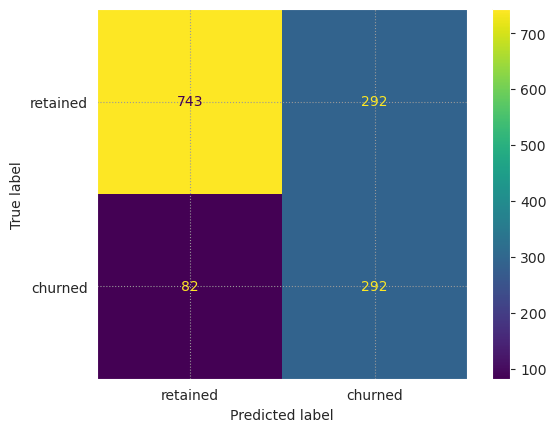

In [136]:
# Geramos os valores 
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv_bal.classes_)

# Visualizamos a matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

Explicação dos termos:

**True Positive (TP):** O modelo classificou corretamente 743 instâncias como `retained`.

**True Negative (TN):** O modelo classificou corretamente 82 instâncias como `churned`.

**False Positive (FP)**: O modelo erroneamente classificou 292 instâncias como `churned` quando, na verdade, eram `retained` (falsos positivos).

**False Negative (FN):** O modelo erroneamente classificou 292 instâncias como `retained` quando, na verdade, eram `churned` (falsos negativos).

### **Feature importance**

Usamos a função `plot_importance` para visualização de features mais importantes do nosso modelo final.

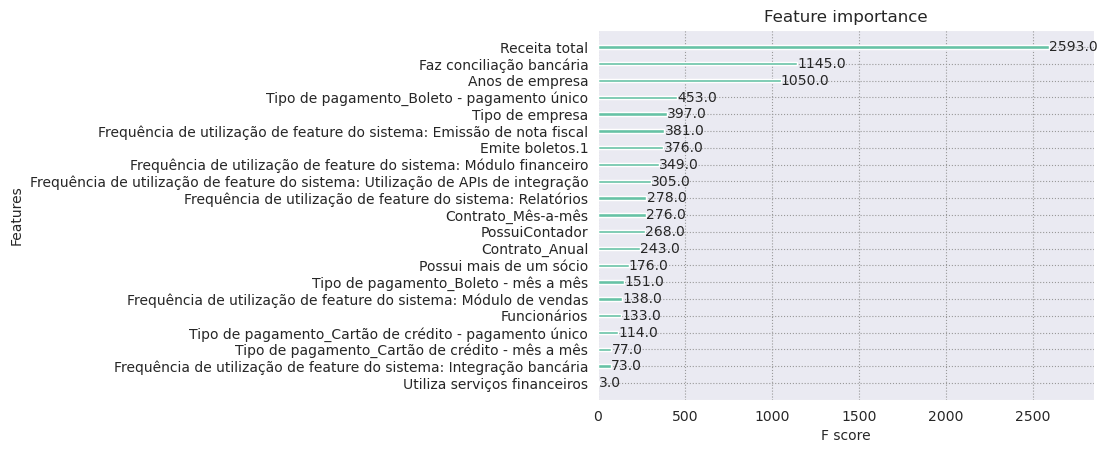

In [134]:
plot_importance(xgb_cv_bal.best_estimator_);

Vamos construir a curva de _precision-recall_ para o modelo XGBoost utilizando os dados de teste.

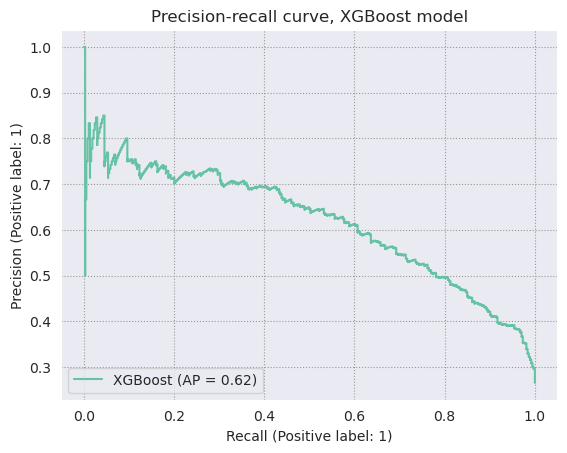

In [135]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv_bal.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

Maior a area sob a curve, melhor perfomance do modelo. À medida que o _recall_ aumenta, é observada uma diminuição na precisão. 

## Conclusões Finais

Neste projeto, desenvolvemos e avaliamos um modelo de aprendizado de máquina com o objetivo de antecipar o churn das empresas que utilizam os serviços da XYZ. Utilizamos diversas variáveis como base para a previsão.

Inicialmente, realizamos uma análise exploratória de dados, incluindo visualização para extrair indicadores relevantes. 
Resolvemos problemas relacionados à presença de valores ausentes, uma vez que estes podem impactar significativamente o desempenho de um modelo de previsão. Nesta etapa extraimos as seguintes unformações:
* A taxa de churn é menor entre as empresas com 3-8 anos de idade, e tende aumentar no grupo de empresas entre 9-23 anos de mercado. Esse padrão pode ser influenciado por diversos fatores, como mudanças na concorrência, evolução do mercado, necessidades e expectativas dos clientes ao longo do tempo, entre outros.
* Empresas que possuem mais de um sócio têm uma taxa de churn menor, de 19.7%. Possivelmente, o número de sócios pode estar correlacionado com a taxa de churn, indicando uma possível área de investigação adicional sobre como a estrutura societária pode influenciar a fidelidade dos clientes.
* Empresas com 6 ou mais funcionários têm uma taxa de churn menor em comparação com aquelas com até 5 funcionários, com uma taxa de aproximadamente 15.45%. Isso pode indicar que empresas maiores podem ter recursos e capacidade organizacional adicionais para manter o contrato com XYZ.
* Empresas que realizam conciliação bancária manualmente tendem a ter uma taxa de churn significativamente maior em comparação com aquelas que utilizam métodos automáticos ou que não realizam a conciliação. Isso pode indicar a importância de processos mais eficientes e automatizados na gestão financeira das empresas para a retenção de empresas-clientes.
* A taxa de churn diminua à medida que o número de meses de permanência na XYZ aumenta. Isso porque clientes que permanecem com um serviço da XYZ por um período mais longo tendem a estar mais satisfeitos ou terem uma maior fidelidade ao produto ou serviço.
* Existe uma correlação entre o período de contrato e a taxa de churn, com contratos mais longos apresentando taxas de churn mais baixas. Isso destaca a importância de estratégias de retenção de clientes diferenciadas, dependendo do tipo de contrato oferecido pela empresa.
* As taxas de churn variam entre os diferentes tipos de pagamento, e isso sugere a importância de entender os motivos e padrões de cancelamento associados a cada forma de pagamento para implementar estratégias eficazes de retenção de empresas-clientes.

Na proxima parte do desafio, fizemos pré-processamento de dados. É a etapa de transformação de dados brutos em uma forma que o modelo de aprendizado de máquina possa entender. Realisamos codificação de variáveis categóricas e normalização dos dados. Para a seleção de variáveis preditoras, utilizamos a matriz de correlação de Pearson. Identificamos multicolinearidade entre algumas variáveis. Optamos por descartar as variáveis `Receita mensal` e `Meses de permanência` na construção do modelo.

Para construção de modelo de previsão, escolhemos Random Forest Claasifier e XGBoost. Nesta etapa, lidamos com dados desbalanceados da variável-alvo `Churn`. Utilizamos uma técnica chamada "Undersampling", consiste em diminuir a quantidade de registros da classe com maior frequência até que a base de dados possua uma quantidade equilibrada entre as classes da variável alvo.

Após a construção do modelo, avaliamos seu desempenho através da pontuação do modelo, para isso escolhemos as métricas de precisão e recall como mais importantes. Observamos que o modelo possui uma precisão mediana (50% de suas previsões positivas estão corretas, ou seja, 50% das previsões feitas pelo modelo como `churn` são as empresas que realmente cancelaram o serviço), e um recall bastante alto - 78%, indicando que o modelo é capaz de identificar corretamente 78% de todos os casos positivos.